# makemore: part 5


Fixing some features

# 1. 🌫️ Fixing loss plot

# 2. 🧅 Creating layers for embedding table and concatenate op

# 3. 🏗️ Pytorch containers

nn.Sequential ~ list of layers

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

#Data load. No changes here

#https://datos.gob.es/es/catalogo/a09002970-municipios-de-espana
# We will instead be using names of villages/cities in Spain. Only 8k data
import pandas as pd

# Read the CSV data
df = pd.read_csv("Municipis_d_Espanya.csv", sep=",")

# Function to clean the names
def clean_name(name):
    # If there's a slash, take the first part
    name = name.split('/')[0]
    # If it's in "Last, First" format, swap it to "First Last"
    if ',' in name:
        parts = name.split(', ')
        if len(parts) == 2:
            name = f"{parts[1]} {parts[0]}"
    return name

# Apply the function to clean names
df["Nom"] = df["Nom"].apply(clean_name)

# Extract only the 'Territorio' column as a list
words = df["Nom"].tolist()

print(f"{len(words)} words")

#Simplifying the problem (lowercase and no accents)
import unidecode
import re

print(words[:1])
words = [re.sub(r'[\(\)\'"]', '', unidecode.unidecode(word).lower()) for word in words]
print(words[:1])

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

8134 words
['Alegría-Dulantzi']
['alegria-dulantzi']
{1: ' ', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 0: '.'}
29
torch.Size([85032, 3]) torch.Size([85032])
torch.Size([10606, 3]) torch.Size([10606])
torch.Size([10768, 3]) torch.Size([10768])


In [13]:
# These classes implement the same API as nn.Module in PyTorch

#--------------------------------------------------------------

class Linear:
    """Simple Linear layer implementation (y = wx + b)"""
    def __init__(self, fan_in, fan_out, bias=True):
        # Initialize weights using Kaiming initialization (scaled by fan_in)
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        # Forward pass: matrix multiplication (and bias addition if present)
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        # Return trainable parameters
        return [self.weight] + ([] if self.bias is None else [self.bias])

#--------------------------------------------------------------

class BatchNorm1d:
    """Batch Normalization layer for stabilizing training"""
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps  # Small constant for avoid /0
        self.momentum = momentum  # For running statistics update
        self.training = True
        # Learnable parameters
        self.gamma = torch.ones(dim)   # Scale parameter
        self.beta = torch.zeros(dim)   # Shift parameter
        # Running statistics for inference
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            # During training: use batch statistics
            xmean = x.mean(0, keepdim=True)  # Batch mean
            xvar = x.var(0, keepdim=True)    # Batch variance
            
            # Update running statistics for inference
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            # During inference: use running statistics
            xmean = self.running_mean
            xvar = self.running_var
        
        # Normalize and apply learnable parameters
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta          # Scale and shift
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

#--------------------------------------------------------------
class Tanh:
    """Hyperbolic tangent activation function"""
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []  # No trainable parameters

In [31]:
# 🧅

# One more time doing it pytorch-like

# -----------------------------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        # Create a learnable embedding table/matrix
        # num_embeddings: total number of unique tokens/items in vocabulary
        # embedding_dim: dimension of each embedding vector
        # shape: (vocabulary_size, embedding_dimension)
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        # IX is a tensor of indices into the embedding table
        # Each index selects a row from the embedding weight matrix
        # For example, if IX contains [3, 1, 4], this selects rows 3, 1, and 4
        # Returns tensor containing embedding vectors for each index
        self.out = self.weight[IX]
        return self.out
        
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------

class Flatten:      
    def __call__(self, x):
        self.out = x.view(x.shape[0],-1)
        return self.out
        
    def parameters(self):
        # This layer has no learnable parameters
        return []

In [36]:
#🏗️

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [34]:
# Model architecture parameters
n_embd = 10      # Dimension of character embeddings
n_hidden = 300   # Number of neurons in hidden layers

torch.manual_seed(42);

#C = torch.randn((vocab_size, n_embd))# 🧅

#🏗️ layers = [  # Deleting naked list of layers. We now have a model object
model = Sequential([
Embedding(vocab_size, n_embd),# 🧅
Flatten(),# 🧅
Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
Linear(n_hidden, vocab_size, bias=False),
])


with torch.no_grad():
    # Scale down the last layer to make initial predictions less confident
    model.layers[-1].weight *= 0.1

# Collect all trainable parameters
#🧅parameters = '''[C]''' + [p for layer in layers for p in layer.parameters()]

#🏗️parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()#🏗️

print(sum(p.nelement() for p in parameters))  # Total number of parameters

# Enable gradient computation for all parameters
for p in parameters:
    p.requires_grad = True

18590


In [37]:
# Training hyperparameters
max_steps = 200000
batch_size = 64
lossi = []  # Store loss history (log10)

for i in range(max_steps):
    
    # Create minibatch by random sampling
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch of inputs and targets
    
    # Forward pass--->
    x=Xb
    #🧅emb = C[Xb]  # Transform characters into embedding vectors
    #🧅x = emb.view(emb.shape[0], -1)  # Flatten the embeddings for the linear layer
    
    #🏗️for layer in layers:
    #🏗️    x = layer(x)  # Pass through each layer sequentially
    

    logits=model(x)#🏗️
    
    loss = F.cross_entropy(logits, Yb)  # Calculate cross entropy loss
    
    # Backward pass<----  
    # Zero all parameter gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Parameter update with learning rate decay
    lr = 0.1 if i < 150000 else 0.01  # Reduce learning rate after 150k steps. Commenting this after bad results
    for p in parameters:
        p.data += -lr * p.grad  # Simple SGD update
    
    # Monitoring and logging
    if i % 5000 == 0:  # Print progress every 5k steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Store loss in log scale
    lossi.append(loss.log10().item())




      0/ 200000: 3.3780
   5000/ 200000: 1.8779


KeyboardInterrupt: 

_______________________

In [38]:
for layer in model.layers:
    layer.training=False

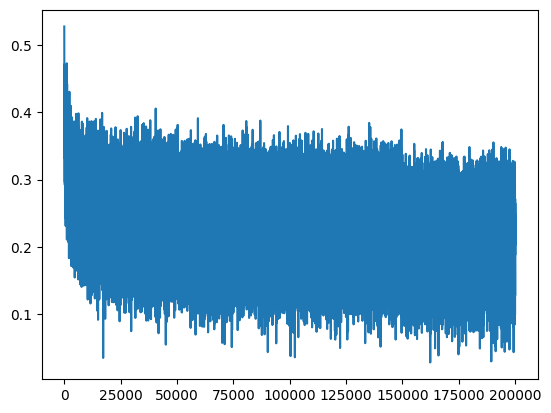

In [ ]:
#probably our batch size is too small. we got lucky batches or unlucky batches

plt.plot(lossi)

In [39]:
#🌫️ Fixing loss plot

lossi_tensor=torch.tensor(lossi)
# Reshape the tensor and calculate mean values for plotting:
# view(-1, 1000) reshapes the tensor into rows of 1000 values each
# mean(1) calculates the mean along dimension 1 (across each row)
#    - This gives you the average loss for each group of 1000 iterations
plt.plot(lossi_tensor.view(-1,1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 6794

In [18]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    
    #🏗️ emb = C[x] # (N, block_size, n_embd)
    #🏗️ x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    #🏗️ for layer in layers:
    #🏗️     x=layer(x)
    #🏗️ loss=F.cross_entropy(x,y)

    #🏗️
    logits=model(x)
    loss=F.cross_entropy(logits,y)

    print(split,loss.item)

split_loss('train')
split_loss('val')

train <built-in method item of Tensor object at 0x7fc8bf0a6940>
val <built-in method item of Tensor object at 0x7fc8bf064140>


In [40]:
for _ in range(100):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #🏗️ emb = C[torch.tensor([context])] # (1,block_size,d)
        #🏗️ x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        #🏗️ for layer in layers:
        #🏗️     x=layer(x)
        logits=model(torch.tensor([context]))
        probs= F.softmax(logits,dim=1)

        ix=torch.multinomial(probs, num_samples=1).item()
        context=context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

montera.
santales de villares.
vilesa.
juiconenqueracera.
forti de vinonoralotazalan.
cimialemocerelles a-adenijara.
san juanigro de rurinarblia de serramo.
el arucuno.
fortirafo algaretiguesas de buas.
penoviancoquelo de la sempo.
rabajo.
navios.
pillarenca del vallar cra.
santin.
santa.
villosa.
aldega.
rez.
guenas mortia.
canal.
cortin.
duz de bledrimerio.
brit dello.
el sigaan mi lle de gurgorre.
cordejueyner.
cos.
cinevo.
bringoo arcobivardez.
condalaran.
cadlagranavarra.
bapa.
tellodesa.
tolillahuentercasal del tejo.
villanomenc munco.
manadarzarral de farrias.
veira.
o banyo.
tlia de crada.
santadiles.
ajera.
el reixera.
can.
cin.
es.
murias calar de la frentejarzas de artin.
baia.
o cruel valmoyoles.
bie.
esoros.
pilla.
mura.
hargallo.
mur.
bineca.
saco.
cro.
muris.
ubosa de lar de lragoi.
villo.
benabreanta rean.
moria del modeprion.
erterreros.
balbuela.
haro de la de sies campresmos.
villas cro.
cas.
kerecuenyena.
terra de pedrepillafrajos.
cerc.
poltomera.
afuentebaltertin.